In [1]:
#pip install -r requirements.txt

import pandas as pd
import numpy as np
from sklearn import linear_model
import matplotlib.pyplot as plt

import seaborn as sns

import scipy.stats as stats
from scipy.stats import norm

from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from IPython.display import display, HTML

In [2]:
##################################__DATA LOAD__################################################

In [3]:
interest_rate = pd.read_csv('./data/interest_rate.csv')
oil_price = pd.read_csv('./data/oil_price.csv')
#cpi = pd.read_csv('./data/cpi.csv')
inflation = pd.read_csv('./data/inflation.csv')

In [4]:
##################################__DATA SANITY CHECKS__################################################

In [5]:
interest_rate.head(1000)

,location,interest_rate,year,month
0,AUS,5.00,2000,1
1,AUS,5.48,2000,2
2,AUS,5.50,2000,3
3,AUS,5.72,2000,4
4,AUS,5.98,2000,5
...,...,...,...,...
995,USA,0.09,2014,9
996,USA,0.09,2014,10
997,USA,0.09,2014,11
998,USA,0.12,2014,12


In [6]:
#cpi.head(2000)

In [7]:
oil_price.head(1000)

,oil_price,year,month,location,oil_price_lag_1m,oil_price_lag_2m,oil_price_lag_3m,oil_price_lag_4m,oil_price_lag_5m,oil_price_lag_6m
0,27.501304,2003,7,AUS,26.778571,25.629545,25.239048,29.440000,31.643500,30.336364
1,28.694286,2003,8,AUS,27.501304,26.778571,25.629545,25.239048,29.440000,31.643500
2,26.150909,2003,9,AUS,28.694286,27.501304,26.778571,25.629545,25.239048,29.440000
3,28.349130,2003,10,AUS,26.150909,28.694286,27.501304,26.778571,25.629545,25.239048
4,28.482500,2003,11,AUS,28.349130,26.150909,28.694286,27.501304,26.778571,25.629545
...,...,...,...,...,...,...,...,...,...,...
970,18.965000,1993,3,EU,18.960000,18.700000,18.045000,16.705000,16.900000,16.520000
971,18.410000,1993,2,EU,18.965000,18.960000,18.700000,18.045000,16.705000,16.900000
972,17.755000,1993,1,EU,18.410000,18.965000,18.960000,18.700000,18.045000,16.705000
973,18.290000,1992,12,EU,17.755000,18.410000,18.965000,18.960000,18.700000,18.045000


In [8]:
#merge all separate data into one dataframe

df = interest_rate.merge(oil_price, on=['location', 'year', 'month'], suffixes=('', '_delme'))
#df = df.merge(cpi, on=['location', 'year', 'month'], suffixes=('', '_delme'))
df = df.merge(inflation, on=['location', 'year', 'month'], suffixes=('', '_delme'))
df = df[[c for c in df.columns if not c.endswith('_delme')]]

In [9]:
df.head(3000)

,location,interest_rate,year,month,oil_price,oil_price_lag_1m,oil_price_lag_2m,oil_price_lag_3m,oil_price_lag_4m,oil_price_lag_5m,oil_price_lag_6m,inflation,inflation_lag_6m
0,AUS,4.75,2003,7,27.501304,26.778571,25.629545,25.239048,29.440000,31.643500,30.336364,2.600000,2.933333
1,AUS,4.75,2003,8,28.694286,27.501304,26.778571,25.629545,25.239048,29.440000,31.643500,2.600000,3.066667
2,AUS,4.75,2003,9,26.150909,28.694286,27.501304,26.778571,25.629545,25.239048,29.440000,2.600000,3.200000
3,AUS,4.75,2003,10,28.349130,26.150909,28.694286,27.501304,26.778571,25.629545,25.239048,2.566667,3.100000
4,AUS,4.98,2003,11,28.482500,28.349130,26.150909,28.694286,27.501304,26.778571,25.629545,2.533333,3.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
768,USA,0.77,2022,5,109.550000,101.780000,108.500000,91.640000,83.220000,71.710000,79.150000,8.600000,5.000000
769,USA,1.21,2022,6,114.840000,109.550000,101.780000,108.500000,91.640000,83.220000,71.710000,9.100000,5.400000
770,USA,1.68,2022,7,101.620000,114.840000,109.550000,101.780000,108.500000,91.640000,83.220000,8.500000,5.400000
771,USA,2.33,2022,8,93.670000,101.620000,114.840000,109.550000,101.780000,108.500000,91.640000,8.300000,5.300000


In [10]:
#Columns present in the dataset
df.columns

Index(['location', 'interest_rate', 'year', 'month', 'oil_price',
       'oil_price_lag_1m', 'oil_price_lag_2m', 'oil_price_lag_3m',
       'oil_price_lag_4m', 'oil_price_lag_5m', 'oil_price_lag_6m', 'inflation',
       'inflation_lag_6m'],
      dtype='object')

In [11]:
#Checking for null values
df.isnull().sum()

location            0
interest_rate       0
year                0
month               0
oil_price           0
oil_price_lag_1m    0
oil_price_lag_2m    0
oil_price_lag_3m    0
oil_price_lag_4m    0
oil_price_lag_5m    0
oil_price_lag_6m    0
inflation           0
inflation_lag_6m    0
dtype: int64

In [12]:
#Checking datatypes of columns
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 773 entries, 0 to 772
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   location          773 non-null    object 
 1   interest_rate     773 non-null    float64
 2   year              773 non-null    int64  
 3   month             773 non-null    int64  
 4   oil_price         773 non-null    float64
 5   oil_price_lag_1m  773 non-null    float64
 6   oil_price_lag_2m  773 non-null    float64
 7   oil_price_lag_3m  773 non-null    float64
 8   oil_price_lag_4m  773 non-null    float64
 9   oil_price_lag_5m  773 non-null    float64
 10  oil_price_lag_6m  773 non-null    float64
 11  inflation         773 non-null    float64
 12  inflation_lag_6m  773 non-null    float64
dtypes: float64(10), int64(2), object(1)
memory usage: 84.5+ KB


In [13]:
#Stats of data
df.describe()

,interest_rate,year,month,oil_price,oil_price_lag_1m,oil_price_lag_2m,oil_price_lag_3m,oil_price_lag_4m,oil_price_lag_5m,oil_price_lag_6m,inflation,inflation_lag_6m
count,773.000000,773.00000,773.000000,773.000000,773.000000,773.000000,773.000000,773.000000,773.000000,773.000000,773.000000,773.000000
mean,2.284654,2011.34282,6.465718,65.526925,65.480762,65.393312,65.274432,65.129304,64.993790,64.874120,2.231565,2.052393
std,2.136572,6.31227,3.446170,27.478049,27.542550,27.570131,27.569179,27.490030,27.442026,27.437378,1.435083,1.103643
min,0.046800,2000.00000,1.000000,16.550000,16.550000,16.550000,16.550000,16.550000,16.550000,16.550000,-2.100000,-2.100000
25%,0.419900,2006.00000,3.000000,44.720000,44.710000,44.650000,44.600000,44.378571,43.885000,43.424348,1.500000,1.433333
50%,1.500000,2011.00000,6.000000,62.585000,62.480000,62.370000,62.356667,62.330000,62.325000,62.230000,2.100000,2.100000
75%,4.462300,2017.00000,9.000000,85.060435,85.060435,84.985000,84.480000,84.400000,84.370000,84.140000,2.800000,2.700000
max,7.250000,2022.00000,12.000000,134.190000,134.190000,134.190000,134.190000,134.190000,134.190000,134.190000,9.100000,5.600000


In [14]:
df.head(1000)

,location,interest_rate,year,month,oil_price,oil_price_lag_1m,oil_price_lag_2m,oil_price_lag_3m,oil_price_lag_4m,oil_price_lag_5m,oil_price_lag_6m,inflation,inflation_lag_6m
0,AUS,4.75,2003,7,27.501304,26.778571,25.629545,25.239048,29.440000,31.643500,30.336364,2.600000,2.933333
1,AUS,4.75,2003,8,28.694286,27.501304,26.778571,25.629545,25.239048,29.440000,31.643500,2.600000,3.066667
2,AUS,4.75,2003,9,26.150909,28.694286,27.501304,26.778571,25.629545,25.239048,29.440000,2.600000,3.200000
3,AUS,4.75,2003,10,28.349130,26.150909,28.694286,27.501304,26.778571,25.629545,25.239048,2.566667,3.100000
4,AUS,4.98,2003,11,28.482500,28.349130,26.150909,28.694286,27.501304,26.778571,25.629545,2.533333,3.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
768,USA,0.77,2022,5,109.550000,101.780000,108.500000,91.640000,83.220000,71.710000,79.150000,8.600000,5.000000
769,USA,1.21,2022,6,114.840000,109.550000,101.780000,108.500000,91.640000,83.220000,71.710000,9.100000,5.400000
770,USA,1.68,2022,7,101.620000,114.840000,109.550000,101.780000,108.500000,91.640000,83.220000,8.500000,5.400000
771,USA,2.33,2022,8,93.670000,101.620000,114.840000,109.550000,101.780000,108.500000,91.640000,8.300000,5.300000


In [15]:
##################################__Data Prep__################################################

In [16]:
df_au = df[df['location'] == 'AUS']
df_us = df[df['location'] == 'USA']
df_eu = df[df['location'] == 'EU']

excluded_features =['location','year','month']

features = [column for column in df.columns 
    if not any(excluded_feature in column for excluded_feature in excluded_features)]

#features_without_lag = [feature for feature in features
#    if feature.find('_lag_') == -1]

features_without_lag = ['oil_price','inflation','interest_rate']

In [17]:
##################################__CHANGE OVER TIME__################################################

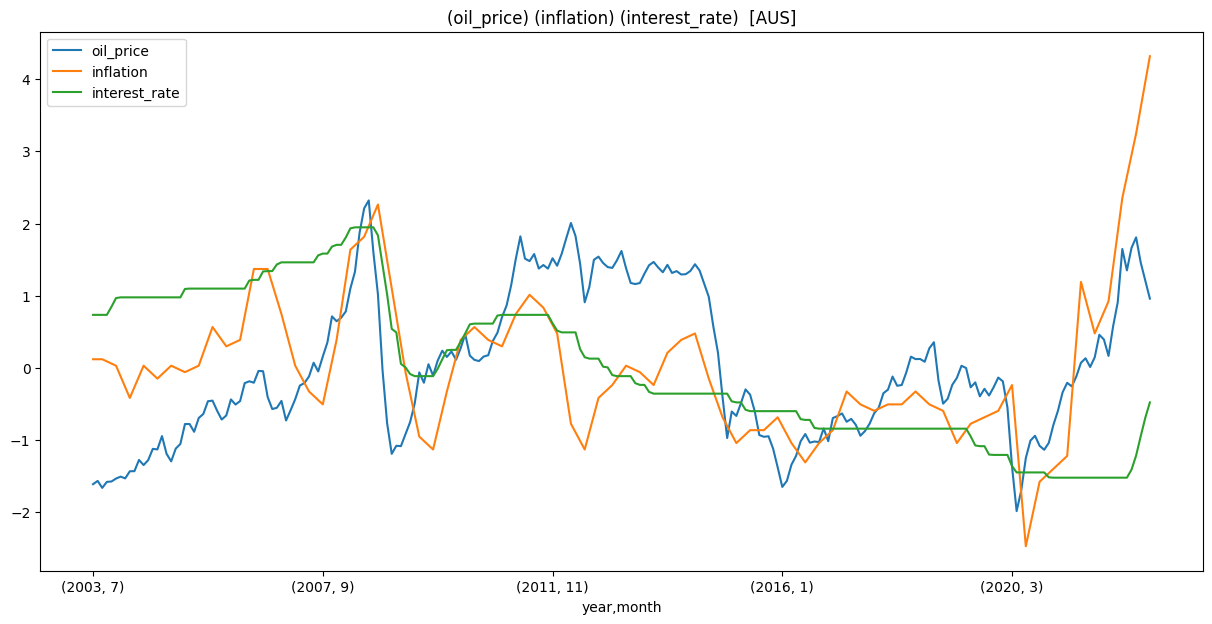

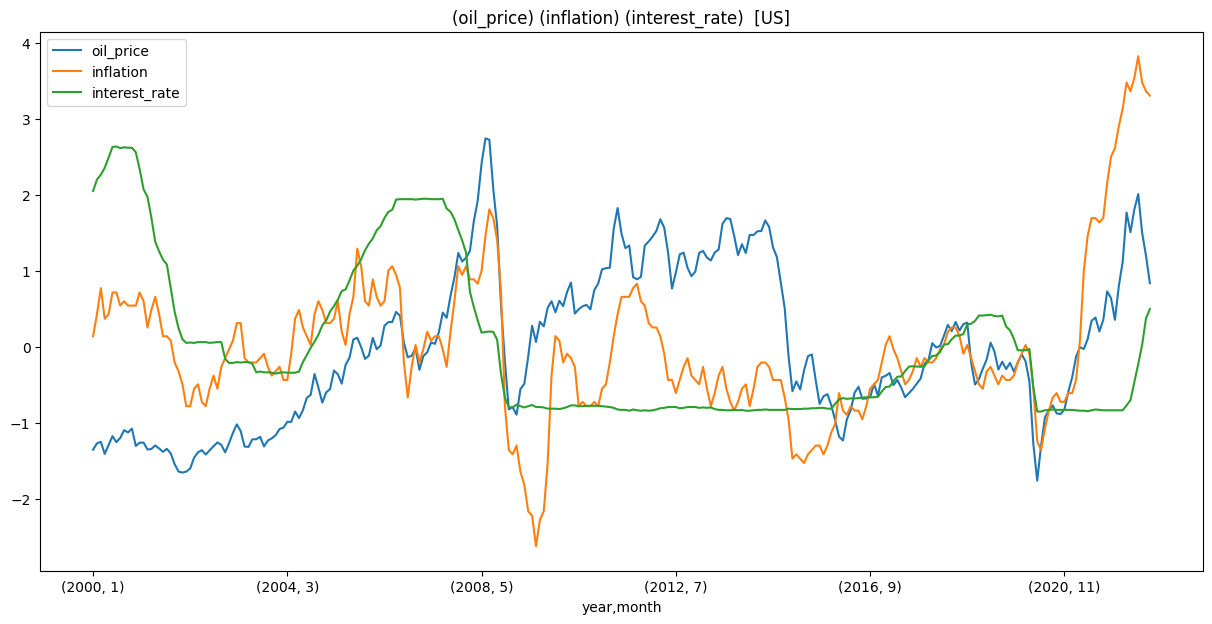

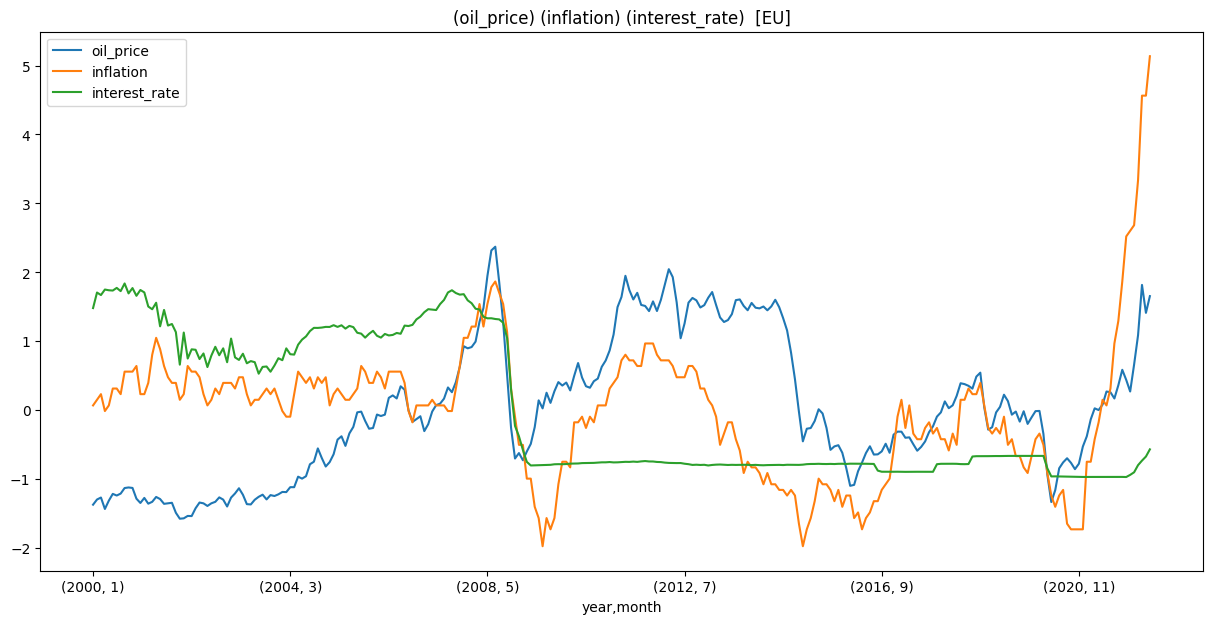

In [18]:
current_plt_figsize = plt.rcParams['figure.figsize']

plt.rcParams['figure.figsize'] = [15,7]

def scaled_features_plot(df_for_plot,col_names,country_name):
    scaled_features = df_for_plot.copy()
    features = scaled_features[col_names]
    scaler = StandardScaler().fit(features.values)
    features = scaler.transform(features.values)

    scaled_features[col_names] = features

    scaled_pivot_table = pd.pivot_table(scaled_features.reset_index(),           
                   index=['year','month'], values=col_names
              )[col_names]
    
    scaled_pivot_table.plot(subplots=False,title=f'({") (".join(col_names)})  [{country_name}]')

scaled_features_plot(df_au,features_without_lag,'AUS')
scaled_features_plot(df_us,features_without_lag,'US')
scaled_features_plot(df_eu,features_without_lag,'EU')

plt.rcParams['figure.figsize'] = current_plt_figsize

In [19]:
##################################__FEATURES_COMPARE_PER_COUNTRY__################################################

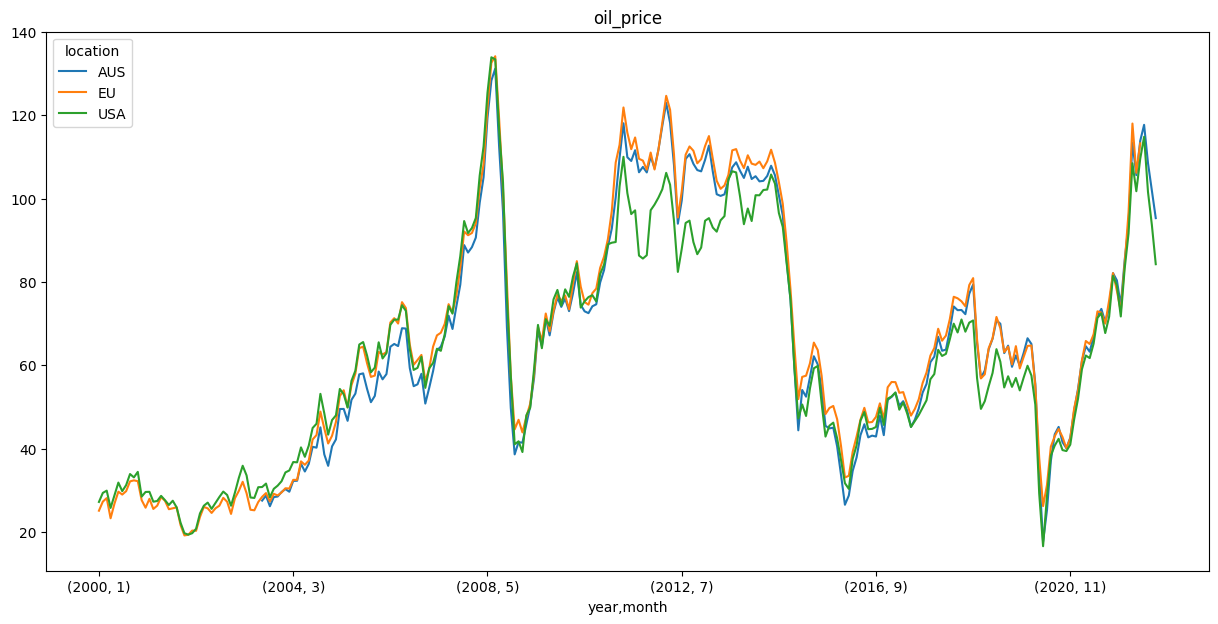

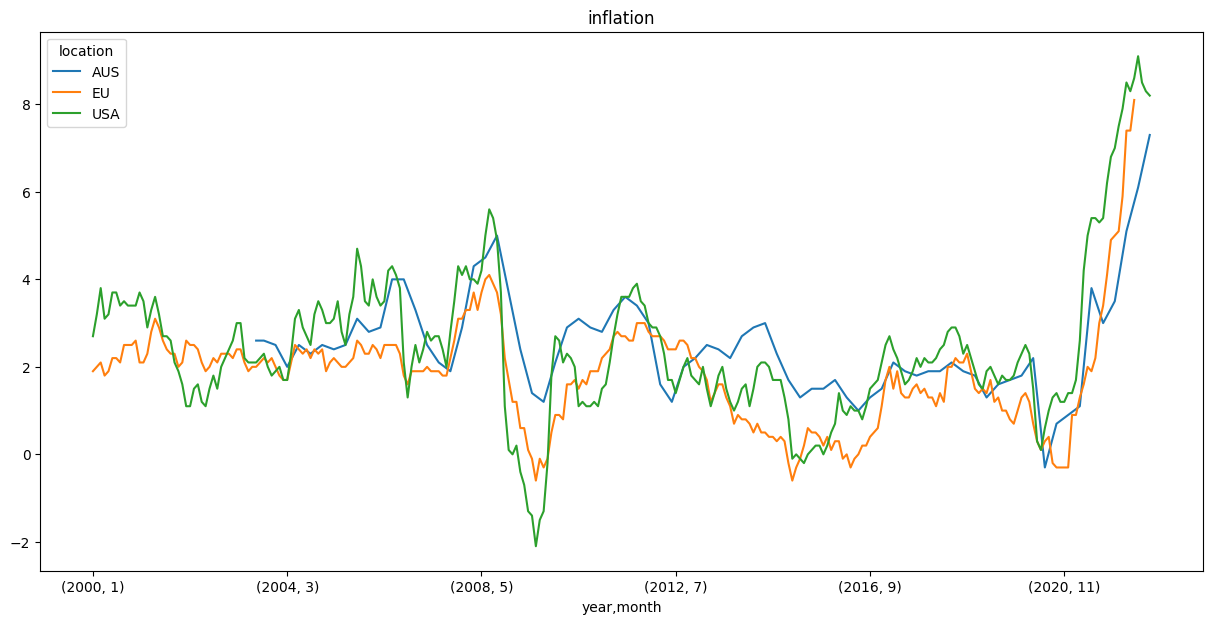

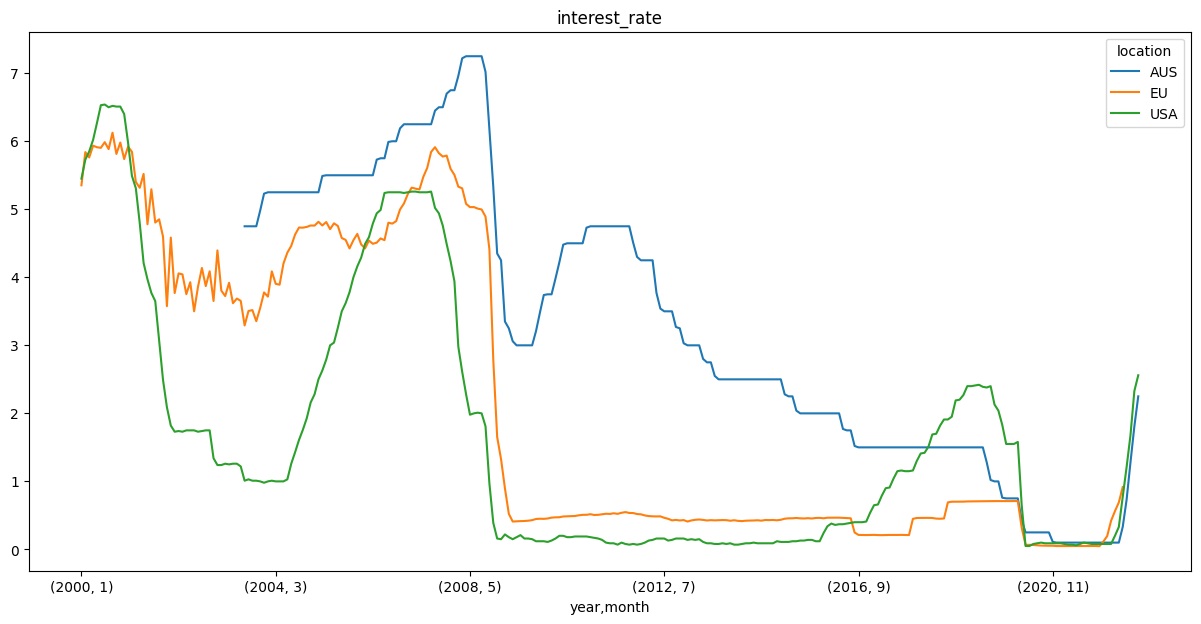

In [20]:
current_plt_figsize = plt.rcParams['figure.figsize']

plt.rcParams['figure.figsize'] = [15,7]

for feature in features_without_lag:
    pd.pivot_table(df, index=['year','month'], columns='location', values=feature
                  ).plot(title=feature)
    
plt.rcParams['figure.figsize'] = current_plt_figsize

In [21]:
##################################__CORELATION__################################################

In [22]:
method='pearson'
min_periods=1




================================CORRELATION====================================
================================COUNTRY [AUD]===================================


,interest_rate,year,month,oil_price,oil_price_lag_1m,oil_price_lag_2m,oil_price_lag_3m,oil_price_lag_4m,oil_price_lag_5m,oil_price_lag_6m,inflation,inflation_lag_6m
interest_rate,1.000000,-0.917106,0.014637,0.107488,0.108469,0.103678,0.093308,0.080588,0.062588,0.041148,0.354477,0.510251
year,-0.917106,1.000000,-0.067845,0.118219,0.120360,0.121862,0.122868,0.121091,0.120175,0.122036,-0.163194,-0.547566
month,0.014637,-0.067845,1.000000,-0.024404,0.022177,0.049828,0.052548,0.041160,0.016836,-0.018155,0.003026,0.014936
oil_price,0.107488,0.118219,-0.024404,1.000000,0.972390,0.922751,0.865573,0.813153,0.765208,0.721776,0.463517,0.123671
oil_price_lag_1m,0.108469,0.120360,0.022177,0.972390,1.000000,0.972708,0.923706,0.867350,0.814538,0.766455,0.484550,0.119536
oil_price_lag_2m,0.103678,0.121862,0.049828,0.922751,0.972708,1.000000,0.972961,0.924487,0.867794,0.815023,0.486080,0.113771
oil_price_lag_3m,0.093308,0.122868,0.052548,0.865573,0.923706,0.972961,1.000000,0.973141,0.924377,0.867854,0.463571,0.109288
oil_price_lag_4m,0.080588,0.121091,0.041160,0.813153,0.867350,0.924487,0.973141,1.000000,0.973029,0.924568,0.418726,0.106691
oil_price_lag_5m,0.062588,0.120175,0.016836,0.765208,0.814538,0.867794,0.924377,0.973029,1.000000,0.973159,0.362817,0.114234
oil_price_lag_6m,0.041148,0.122036,-0.018155,0.721776,0.766455,0.815023,0.867854,0.924568,0.973159,1.000000,0.302890,0.134599


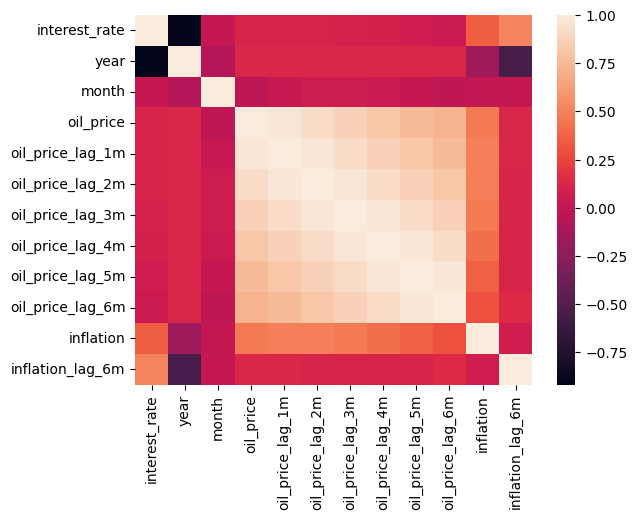




================================CORRELATION====================================
================================COUNTRY [USA]===================================


,interest_rate,year,month,oil_price,oil_price_lag_1m,oil_price_lag_2m,oil_price_lag_3m,oil_price_lag_4m,oil_price_lag_5m,oil_price_lag_6m,inflation,inflation_lag_6m
interest_rate,1.000000,-0.557329,-0.015702,-0.280337,-0.284289,-0.292999,-0.306845,-0.324433,-0.341563,-0.357302,0.282216,0.360040
year,-0.557329,1.000000,-0.024359,0.356424,0.357103,0.356990,0.356783,0.354833,0.354310,0.355685,0.068241,-0.234462
month,-0.015702,-0.024359,1.000000,0.008380,0.052910,0.076750,0.077992,0.065770,0.045965,0.012897,-0.012769,0.005673
oil_price,-0.280337,0.356424,0.008380,1.000000,0.975246,0.933255,0.885728,0.840862,0.797769,0.758403,0.328672,0.022604
oil_price_lag_1m,-0.284289,0.357103,0.052910,0.975246,1.000000,0.975569,0.934216,0.888180,0.842739,0.799118,0.320263,0.037333
oil_price_lag_2m,-0.292999,0.356990,0.076750,0.933255,0.975569,1.000000,0.975757,0.935302,0.888807,0.843082,0.283347,0.043857
oil_price_lag_3m,-0.306845,0.356783,0.077992,0.885728,0.934216,0.975757,1.000000,0.976151,0.935360,0.888771,0.232271,0.044206
oil_price_lag_4m,-0.324433,0.354833,0.065770,0.840862,0.888180,0.935302,0.976151,1.000000,0.976054,0.935475,0.167461,0.043137
oil_price_lag_5m,-0.341563,0.354310,0.045965,0.797769,0.842739,0.888807,0.935360,0.976054,1.000000,0.976149,0.102038,0.045107
oil_price_lag_6m,-0.357302,0.355685,0.012897,0.758403,0.799118,0.843082,0.888771,0.935475,0.976149,1.000000,0.038269,0.051952


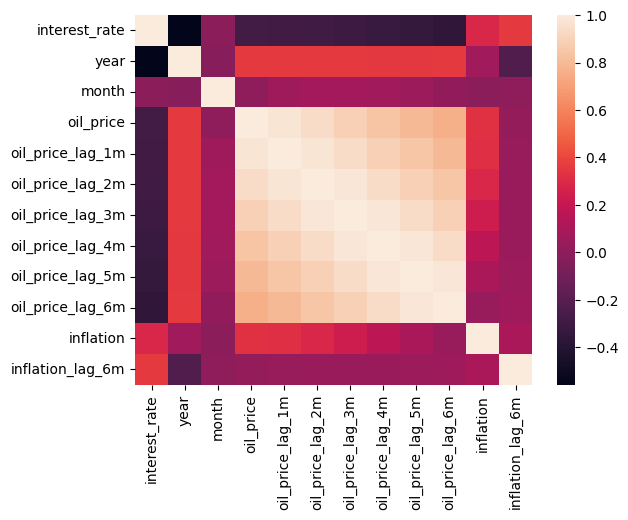




================================CORRELATION====================================
================================COUNTRY [EU]===================================


,interest_rate,year,month,oil_price,oil_price_lag_1m,oil_price_lag_2m,oil_price_lag_3m,oil_price_lag_4m,oil_price_lag_5m,oil_price_lag_6m,inflation,inflation_lag_6m
interest_rate,1.000000,-0.835791,-0.006033,-0.389739,-0.391861,-0.396607,-0.401270,-0.404273,-0.406880,-0.409004,0.366693,0.361647
year,-0.835791,1.000000,-0.032799,0.389648,0.392627,0.393412,0.392344,0.388894,0.385877,0.383224,-0.201564,-0.473974
month,-0.006033,-0.032799,1.000000,0.001814,-0.030169,-0.044493,-0.038085,-0.028221,-0.009253,0.015946,-0.035893,0.000828
oil_price,-0.389739,0.389648,0.001814,1.000000,0.981744,0.948088,0.909888,0.872584,0.837954,0.805622,0.248584,0.070517
oil_price_lag_1m,-0.391861,0.392627,-0.030169,0.981744,1.000000,0.981489,0.947451,0.908312,0.871303,0.836944,0.254130,0.062555
oil_price_lag_2m,-0.396607,0.393412,-0.044493,0.948088,0.981489,1.000000,0.981390,0.946888,0.907804,0.870879,0.245093,0.055399
oil_price_lag_3m,-0.401270,0.392344,-0.038085,0.909888,0.947451,0.981390,1.000000,0.981231,0.946668,0.907562,0.232209,0.045218
oil_price_lag_4m,-0.404273,0.388894,-0.028221,0.872584,0.908312,0.946888,0.981231,1.000000,0.981158,0.946501,0.215997,0.034335
oil_price_lag_5m,-0.406880,0.385877,-0.009253,0.837954,0.871303,0.907804,0.946668,0.981158,1.000000,0.981107,0.202051,0.019821
oil_price_lag_6m,-0.409004,0.383224,0.015946,0.805622,0.836944,0.870879,0.907562,0.946501,0.981107,1.000000,0.189547,0.006843


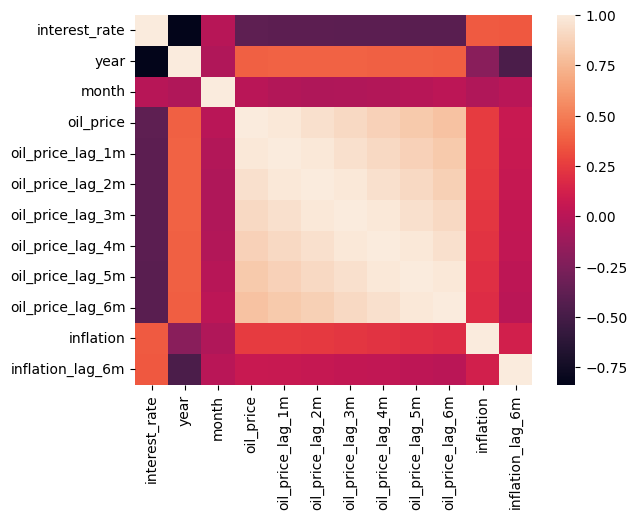

In [23]:
def correlation(df_country,country_name):
    print()
    print()
    print()
    print(f'===============================================================================')
    print(f'================================CORRELATION====================================')
    print(f'===============================================================================')
    print(f'================================COUNTRY [{country_name}]===================================')    
    print(f'===============================================================================')
    df_corr = df_country.corr(numeric_only=True,method=method, min_periods=min_periods)
    display(HTML(df_corr.to_html()))   
    sns.heatmap(df_corr)
    #sns.pairplot(df_country)
    plt.show()
    

correlation(df_au,'AUD')
correlation(df_us,'USA')
correlation(df_eu,'EU')

In [24]:
##################################__Linear Regression__################################################




================================COUNTRY AUS====================================
============================oil_price vs inflation==========================
                            OLS Regression Results                            
Dep. Variable:              inflation   R-squared:                       0.215
Model:                            OLS   Adj. R-squared:                  0.211
Method:                 Least Squares   F-statistic:                     62.66
Date:                Sun, 13 Nov 2022   Prob (F-statistic):           1.05e-13
Time:                        11:03:59   Log-Likelihood:                -326.00
No. Observations:                 231   AIC:                             656.0
Df Residuals:                     229   BIC:                             662.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P

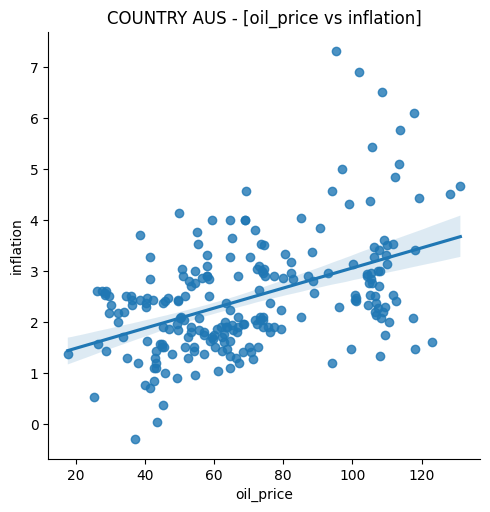




================================COUNTRY USA====================================
============================oil_price vs inflation==========================
                            OLS Regression Results                            
Dep. Variable:              inflation   R-squared:                       0.108
Model:                            OLS   Adj. R-squared:                  0.105
Method:                 Least Squares   F-statistic:                     32.82
Date:                Sun, 13 Nov 2022   Prob (F-statistic):           2.68e-08
Time:                        11:03:59   Log-Likelihood:                -522.63
No. Observations:                 273   AIC:                             1049.
Df Residuals:                     271   BIC:                             1056.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P

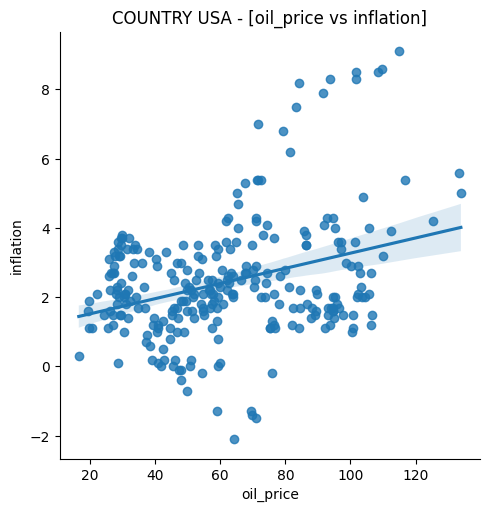




================================COUNTRY EU====================================
============================oil_price vs inflation==========================
                            OLS Regression Results                            
Dep. Variable:              inflation   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                  0.058
Method:                 Least Squares   F-statistic:                     17.59
Date:                Sun, 13 Nov 2022   Prob (F-statistic):           3.74e-05
Time:                        11:04:00   Log-Likelihood:                -427.59
No. Observations:                 269   AIC:                             859.2
Df Residuals:                     267   BIC:                             866.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>

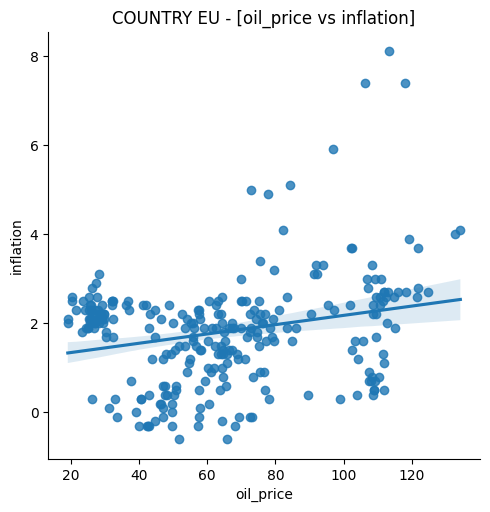




================================COUNTRY AUS====================================
============================['oil_price', 'inflation'] vs interest_rate==========================
                            OLS Regression Results                            
Dep. Variable:          interest_rate   R-squared:                       0.130
Model:                            OLS   Adj. R-squared:                  0.122
Method:                 Least Squares   F-statistic:                     17.00
Date:                Sun, 13 Nov 2022   Prob (F-statistic):           1.31e-07
Time:                        11:04:00   Log-Likelihood:                -478.90
No. Observations:                 231   AIC:                             963.8
Df Residuals:                     228   BIC:                             974.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std 

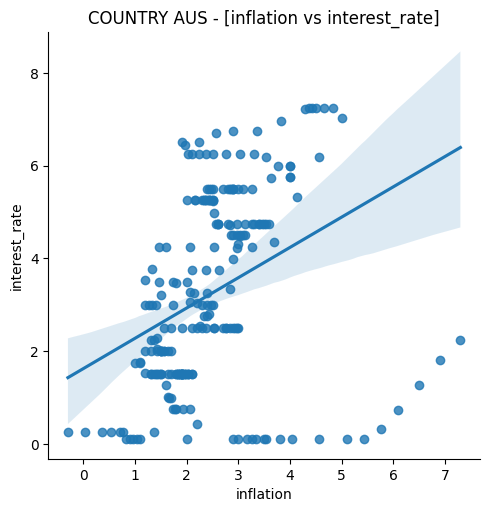




================================COUNTRY USA====================================
============================inflation vs interest_rate==========================
                            OLS Regression Results                            
Dep. Variable:          interest_rate   R-squared:                       0.080
Model:                            OLS   Adj. R-squared:                  0.076
Method:                 Least Squares   F-statistic:                     23.45
Date:                Sun, 13 Nov 2022   Prob (F-statistic):           2.16e-06
Time:                        11:04:00   Log-Likelihood:                -545.73
No. Observations:                 273   AIC:                             1095.
Df Residuals:                     271   BIC:                             1103.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t   

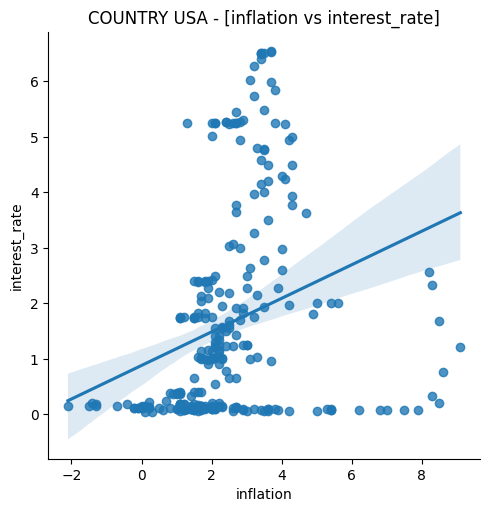




================================COUNTRY EU====================================
============================inflation vs interest_rate==========================
                            OLS Regression Results                            
Dep. Variable:          interest_rate   R-squared:                       0.134
Model:                            OLS   Adj. R-squared:                  0.131
Method:                 Least Squares   F-statistic:                     41.48
Date:                Sun, 13 Nov 2022   Prob (F-statistic):           5.52e-10
Time:                        11:04:00   Log-Likelihood:                -570.16
No. Observations:                 269   AIC:                             1144.
Df Residuals:                     267   BIC:                             1152.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t    

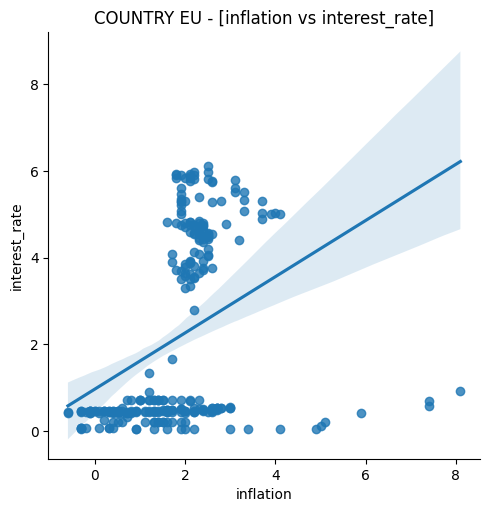

In [25]:
lr_features = [
    ('oil_price', 'inflation'),

    (['oil_price','inflation'], 'interest_rate'),
    (['oil_price_lag_1m','inflation'], 'interest_rate'),      
    (['oil_price_lag_2m','inflation'], 'interest_rate'),
               
    ('inflation', 'interest_rate')
]
   
def linear_regresion_plot(df_feature,feature_x,feature_y,country_name):   
    if(isinstance(feature_x, list) == False):
        x = df_feature[[feature_x]]    
    else:
        x = df_feature[feature_x]
    y = df_feature[[feature_y]]
    print()
    print()
    print()
    print(f'===============================================================================')
    print(f'================================COUNTRY {country_name}====================================')    
    print(f'============================{feature_x} vs {feature_y}==========================') 
    print(f'===============================================================================')
    print(sm.OLS(y, sm.add_constant(x)).fit().summary())
    
    if(isinstance(feature_x, list) == False):
        sns.lmplot(x=feature_x, y=feature_y, data=df_feature)
        plt.title(f'COUNTRY {country_name} - [{feature_x} vs {feature_y}]')
        plt.show()
    
for feature_x, feature_y in lr_features:  
    linear_regresion_plot(df_au,feature_x,feature_y,'AUS')
    linear_regresion_plot(df_us,feature_x,feature_y,'USA')
    linear_regresion_plot(df_eu,feature_x,feature_y,'EU')

In [26]:
##################################__NORMAL DISTRIBUSION__################################################

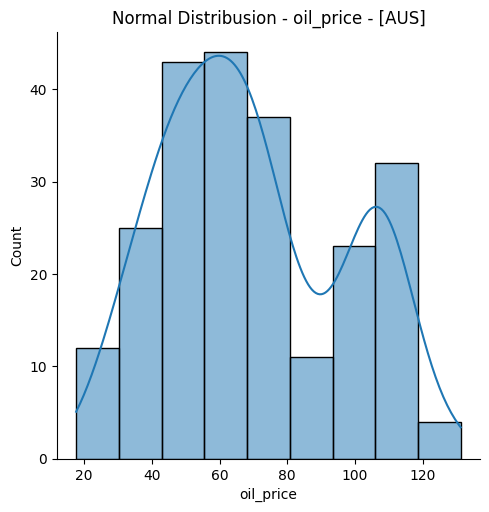

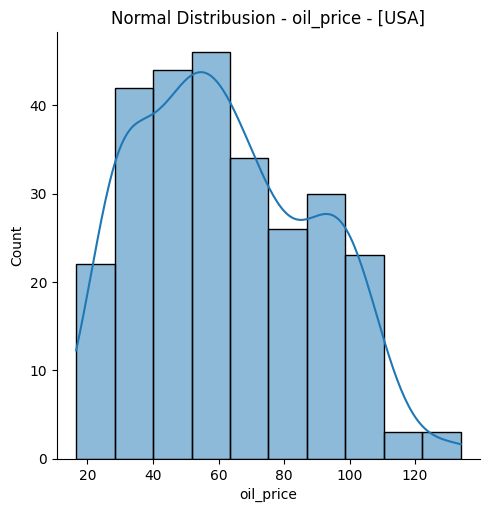

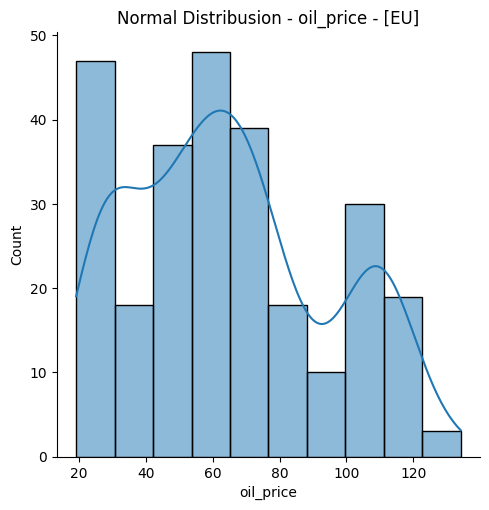

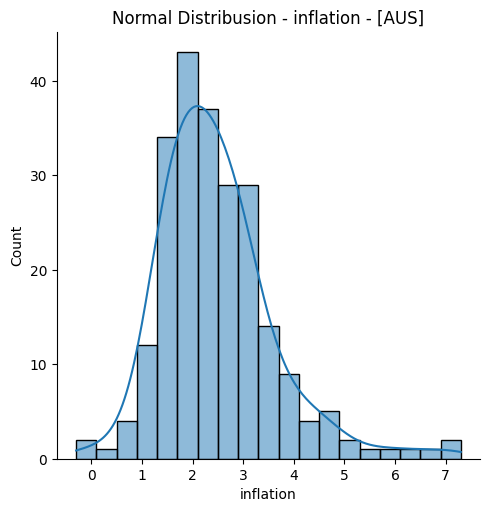

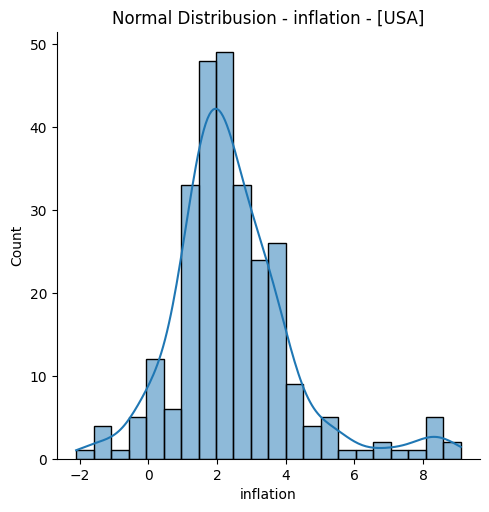

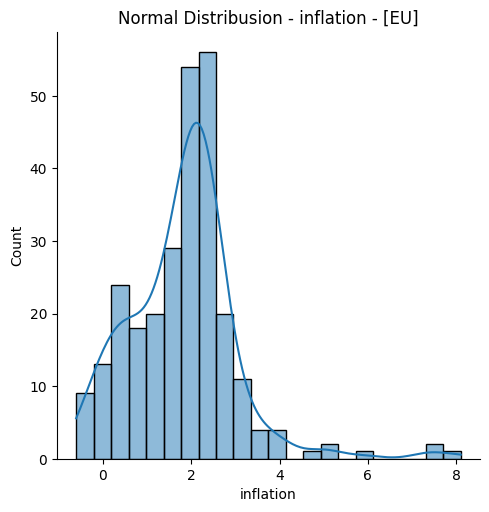

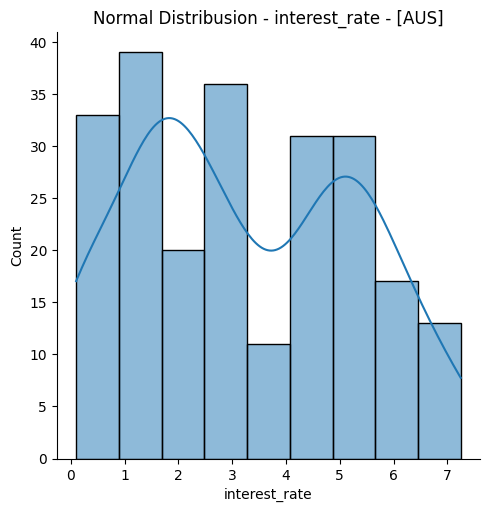

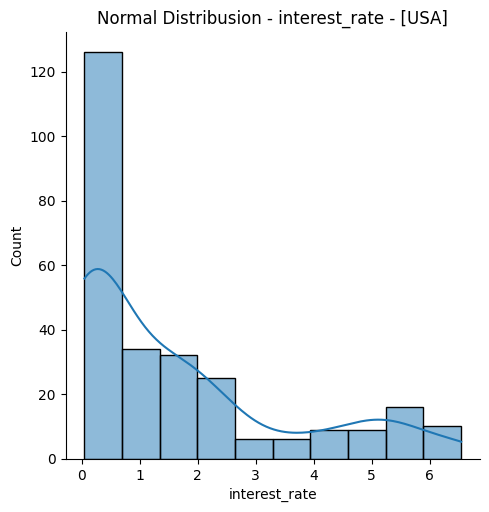

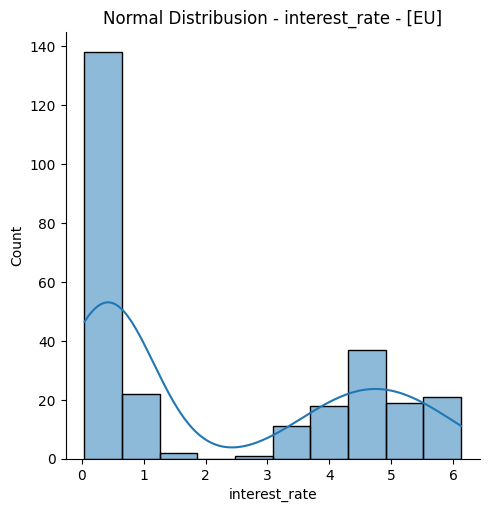

In [27]:
for index, feature in enumerate(features_without_lag):
    sns.displot(df_au[feature], kde=True)
    plt.title(f'Normal Distribusion - {feature} - [AUS]')

    sns.displot(df_us[feature], kde=True)
    plt.title(f'Normal Distribusion - {feature} - [USA]')
    
    sns.displot(df_eu[feature], kde=True)
    plt.title(f'Normal Distribusion - {feature} - [EU]')